In [1]:
import pickle
import matplotlib.pyplot as plt
from scipy.misc import imread
import numpy as np
import glob
import cv2
from sklearn.model_selection import train_test_split

In [2]:
def apply_affine(X, theta, alpha, delta):
    R = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])

    return np.float32(alpha * X.dot(R) + delta)

def augment_image(img, ldmk):
    rows, cols, ch = img.shape
    
    ldmk = np.reshape(ldmk, (28,2))
    
    # Randomly generate transformation params
    theta = np.pi / 15. * (.5 - np.random.rand())
    alpha = np.random.uniform(0.90, 1.10)
    delta = np.random.uniform(-10 , 10, (1,2))
    sigma = np.random.uniform(0.1 , 5, (2,1))
    
        
    # Calculate reference points
    reference_points = np.float32([[1,0],[0,1],[1,1]])
    transformed_points = apply_affine(reference_points, theta, alpha, delta)
    
    # Apply affine transform
    M = cv2.getAffineTransform(reference_points, transformed_points)
    transformed_img = cv2.warpAffine(img, M, (cols,rows), borderMode=cv2.BORDER_REPLICATE)
    
    # Calculate new landmarks
    transformed_ldmk = apply_affine(ldmk, theta, alpha, delta).ravel()
    
    # Apply gaussian blur
    transformed_img = cv2.GaussianBlur(transformed_img,(5,5), sigma[0], sigma[1])
    
    return transformed_img, transformed_ldmk
    

def load_image(image_path, no_alpha=True):
    image = imread(image_path)
    
    # Remove PNG transparency layer
    if no_alpha:
        image = image[:,:,:3]
    
    # load metadata
    metadata_path = image_path.replace('.png', '.pkl')
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
        
    head_pose = np.array(metadata['head_pose']).ravel()
    look_vec = np.array(metadata['look_vec']).ravel()
    
    ldmks = metadata['ldmks']
    ldmks_3d = np.vstack((ldmks['ldmks_lids_3d'], ldmks['ldmks_iris_3d'], ldmks['ldmks_pupil_3d'])).ravel()
    ldmks_2d = np.vstack((ldmks['ldmks_lids_2d'], ldmks['ldmks_iris_2d'], ldmks['ldmks_pupil_2d'])).ravel()
    
    # Augment image
    transformed_img, transformed_ldmk = augment_image(image, ldmks_2d)
        
    return image, ldmks_2d, ldmks_3d, head_pose, look_vec, transformed_img, transformed_ldmk

def get_all_img_paths():
    return list(glob.iglob('./data/**/*.png', recursive=True))

def load_all_images():
    
    paths = get_all_img_paths()
    
    N = len(paths) 
    print('Total num of images %d' % N)
    
    images = np.empty((N, 3, 80, 120), dtype=np.float16)
    augmented_images = np.empty((N, 3, 80, 120), dtype=np.float16)
    ldmks_2d = np.empty((N, 56), dtype=np.float16)
    augmented_ldmks_2d = np.empty((N, 56), dtype=np.float16)
    ldmks_3d = np.empty((N, 84), dtype=np.float16)
    head_pose = np.empty((N, 9), dtype=np.float16)
    look_vec = np.empty((N, 3), dtype=np.float16)
    
    for i, path in enumerate(paths):
        img, l2d, l3d, hp, lv, transformed_img, transformed_ldmk = load_image(path)
        
        images[i,:,:,:] = img.reshape((3,80,120)).astype(np.float16) / 255.
        ldmks_2d[i,:] = l2d
        ldmks_3d[i,:] = l3d
        head_pose[i,:] = hp
        look_vec[i,:] = lv

        # Augmented image
        augmented_images[i,:,:,:] = transformed_img.reshape((3,80,120)).astype(np.float16) / 255.
        augmented_ldmks_2d[i,:] = transformed_ldmk
        
        if i % 1000 == 0:
            print('Processed %d' % i)
    return images, ldmks_2d, augmented_images, augmented_ldmks_2d, ldmks_3d, head_pose, look_vec

In [6]:
images, ldmks_2d, augmented_images, augmented_ldmks_2d, ldmks_3d, head_pose, look_vec = load_all_images()

Total num of images 11382
Processed 0
Processed 1000
Processed 2000
Processed 3000
Processed 4000
Processed 5000
Processed 6000
Processed 7000
Processed 8000
Processed 9000
Processed 10000
Processed 11000


In [43]:
# Train test split
N = len(images)

train_proportion = 0.8
train_idx = np.random.choice(N, int(0.8 * N), replace=False)
test_idx = np.array(list(set(range(N)) - set(train_idx)))

# No overlap between train and test
assert len(set(train_idx).intersection(set(test_idx))) == 0

images_train = images[train_idx, :,:,:]
images_test = images[test_idx, :,:,:]

ldmks_2d_train = ldmks_2d[train_idx, :]
ldmks_2d_test = ldmks_2d[test_idx, :]

ldmks_3d_train = ldmks_3d[train_idx, :]
ldmks_3d_test = ldmks_3d[test_idx, :]

head_pose_train = head_pose[train_idx, :]
head_pose_test = head_pose[test_idx, :]

look_vec_train = look_vec[train_idx, :]
look_vec_test = look_vec[test_idx, :]

# Again for augmented data
train_idx = np.random.choice(N, int(0.8 * N), replace=False)
test_idx = np.array(list(set(range(N)) - set(train_idx)))
# No overlap between train and test
assert len(set(train_idx).intersection(set(test_idx))) == 0


augmented_images_train = augmented_images[train_idx, :,:,:]
augmented_images_test = augmented_images[test_idx, :,:,:]

augmented_ldmks_2d_train = augmented_ldmks_2d[train_idx, :]
augmented_ldmks_2d_test = augmented_ldmks_2d[test_idx, :]

In [44]:
with open('all_data_augmented.pkl', 'wb') as f:
    pickle.dump((images_train ,images_test, ldmks_2d_train , ldmks_2d_test , augmented_images_train, augmented_images_test, augmented_ldmks_2d_train, augmented_ldmks_2d_test, ldmks_3d_train , ldmks_3d_test , head_pose_train ,head_pose_test, look_vec_train, look_vec_test), f)    

In [4]:
with open('all_data_augmented.pkl', 'rb') as f:
    images_train ,images_test, ldmks_2d_train , ldmks_2d_test , augmented_images_train, augmented_images_test, augmented_ldmks_2d_train, augmented_ldmks_2d_test, ldmks_3d_train , ldmks_3d_test , head_pose_train ,head_pose_test, look_vec_train, look_vec_test = pickle.load(f)

In [25]:
from skimage import color

bw_images_train = np.array([color.rgb2grey(img.reshape((80,120,3))) for img in images_train])[:,np.newaxis, :,:]
bw_images_test = np.array([color.rgb2grey(img.reshape((80,120,3))) for img in images_test])[:,np.newaxis, :,:]
bw_augmented_images_train = np.array([color.rgb2grey(img.reshape((80,120,3))) for img in augmented_images_train])[:,np.newaxis, :,:]
bw_augmented_images_test = np.array([color.rgb2grey(img.reshape((80,120,3))) for img in augmented_images_test])[:,np.newaxis, :,:]

with open('all_data_augmented_bw.pkl', 'wb') as f:
    pickle.dump((bw_images_train ,bw_images_test, ldmks_2d_train , ldmks_2d_test , bw_augmented_images_train, 
                 bw_augmented_images_test, augmented_ldmks_2d_train, augmented_ldmks_2d_test, ldmks_3d_train , 
                 ldmks_3d_test , head_pose_train ,head_pose_test, look_vec_train, look_vec_test), f)    

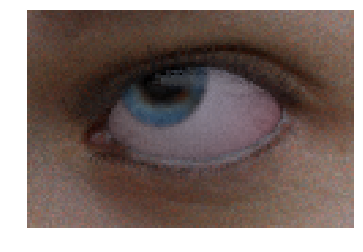

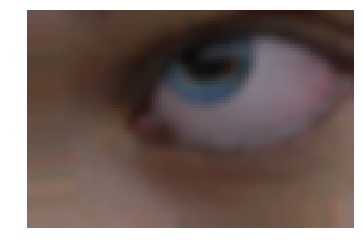

In [25]:
path= './data/f01/f01_1002_0.1963_0.3927.png'
image, ldmks_2d, ldmks_3d, head_pose, look_vec, transformed_img, transformed_ldmk = load_image(path)

plt.imshow(image)
plt.axis('off')
plt.show()

plt.imshow(transformed_img)
plt.axis('off')
plt.show()